In [1]:
#Importing required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
plt.style.use('fivethirtyeight')

from tensorflow import keras   
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_log_error
from keras.layers import SimpleRNN
import statistics

In [12]:
#Loading the dataset
data = pd.read_csv('/content/owid_f1.csv')
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185202,ZWE,Africa,Zimbabwe,2022-05-06,248214.0,164.0,53.143,5473.0,2.0,0.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
185203,ZWE,Africa,Zimbabwe,2022-05-07,248214.0,0.0,48.429,5473.0,0.0,0.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
185204,ZWE,Africa,Zimbabwe,2022-05-08,248352.0,138.0,63.000,5476.0,3.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
185205,ZWE,Africa,Zimbabwe,2022-05-09,248536.0,184.0,85.857,5479.0,3.0,1.286,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [4]:
# Getting the information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3970 entries, 0 to 3969
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   iso_code                                    3970 non-null   object 
 1   continent                                   3152 non-null   object 
 2   location                                    3970 non-null   object 
 3   date                                        3970 non-null   object 
 4   total_cases                                 3956 non-null   float64
 5   new_cases                                   3955 non-null   float64
 6   new_cases_smoothed                          3930 non-null   float64
 7   total_deaths                                3867 non-null   float64
 8   new_deaths                                  3891 non-null   float64
 9   new_deaths_smoothed                         3866 non-null   float64
 10  total_cases_

In [16]:
# Findind the null vaules
data.isnull().sum()

iso_code                                        0
continent                                   10814
location                                        0
date                                            0
total_cases                                  6866
                                            ...  
human_development_index                     36122
excess_mortality_cumulative_absolute       178790
excess_mortality_cumulative                178790
excess_mortality                           178790
excess_mortality_cumulative_per_million    178790
Length: 67, dtype: int64

In [17]:
# Using the Forward filling method, we are trying to eliminate as many null vaules as possible
dat1 = data.ffill()

In [18]:
#Checking the null vaules again
dat1.isnull().sum()

iso_code                                      0
continent                                     0
location                                      0
date                                          0
total_cases                                   0
                                           ... 
human_development_index                       0
excess_mortality_cumulative_absolute       1629
excess_mortality_cumulative                1629
excess_mortality                           1629
excess_mortality_cumulative_per_million    1629
Length: 67, dtype: int64

In [19]:
#looking out how many location we got in the dataset
data.location.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

In [20]:
#Displaying all the records of covid-19 for a paticular country.
data[data['location']=='United States']

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
174472,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
174473,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
174474,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
174475,USA,North America,United States,2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
174476,USA,North America,United States,2020-01-26,5.0,3.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,-8926.0,-3.59,-2.63,-26.811643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175307,USA,North America,United States,2022-05-06,81831608.0,123756.0,71910.571,997318.0,354.0,537.857,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
175308,USA,North America,United States,2022-05-07,81858498.0,26890.0,72342.571,997503.0,185.0,548.286,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
175309,USA,North America,United States,2022-05-08,81863479.0,4981.0,71232.714,997526.0,23.0,549.143,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
175310,USA,North America,United States,2022-05-09,81973661.0,110182.0,73626.857,997740.0,214.0,541.714,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN


Text(0, 0.5, 'New deaths')

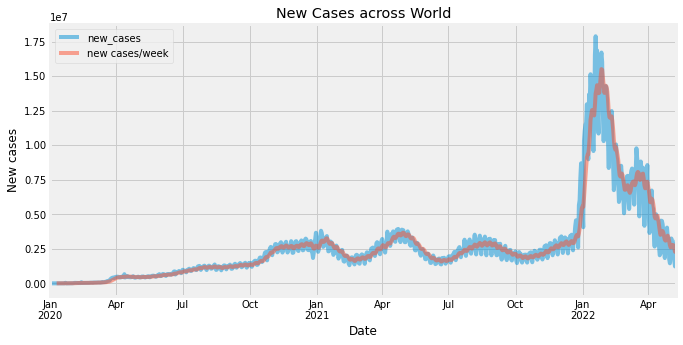

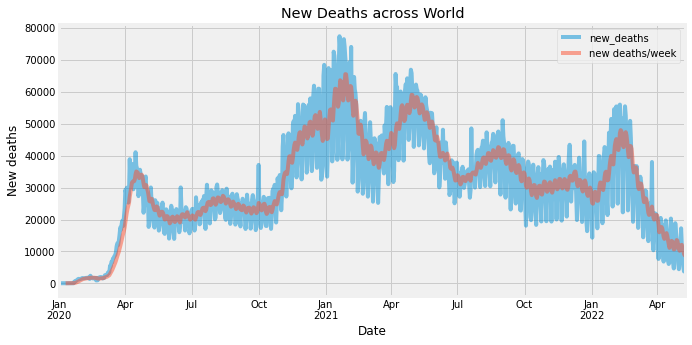

In [54]:
# Observing the pattern on how covid -19 spreads acrosss the country.
dat = dat1.copy()
dat.date = pd.to_datetime(dat['date'])
dat = dat.groupby('date').sum()
dat['new cases/week '] = 0
dat['new deaths/week'] = 0

#Moving average of new cases and new deaths with window=10
dat['new cases/week'] = dat['new_cases'].rolling(10).mean() 
dat['new deaths/week'] = dat['new_deaths'].rolling(10).mean() 

#plot1
p1 = dat[['new_cases', 'new cases/week']].plot(figsize = (10, 5), alpha = 0.5)
plt.title('New Cases across World')
plt.xlabel('Date')
plt.ylabel('New cases')

#plot2
p2 = dat[['new_deaths', 'new deaths/week']].plot(figsize = (10, 5), alpha = 0.5)
plt.title('New Deaths across World')
plt.xlabel('Date')
plt.ylabel('New deaths')

In [55]:
# creating a custom function to see the behaviour of required country.
def covid(df, country):
    #Selecting the required columns for country in dataset
    df = df[df['location']==country].copy()
    df = df[['date','total_cases','new_cases',
         'total_deaths','new_deaths',
         'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
         'new_deaths_per_million', 'new_cases_per_million']].copy()

    df.date = pd.to_datetime(df['date'])

    #Set the date as index 
    df.set_index('date', inplace=True)
    #Compute moving average with window=7 for new_cases and new_deaths
    df['new cases/week'] = 0
    df['new deaths/week'] = 0
    df['new cases per million/week'] = 0
    df['new deaths per million/week'] = 0
    
    df['new cases/week'] = df['new_cases'].rolling(7).mean()
    df['new deaths/week'] = df['new_deaths'].rolling(7).mean()
    df['new cases per million/week'] = df['new_cases_per_million'].rolling(7).mean()
    df['new deaths per million/week'] = df['new_deaths_per_million'].rolling(7).mean()
    
    #Plot new cases, new deaths and people vaccinated 
    df[['new_cases', 'new cases/week']].plot(figsize = (15, 5), alpha = 0.5)
    plt.title(f'New cases in {country} over the period.')

    df[['new_deaths', 'new deaths/week']].plot(figsize = (15, 5), alpha = 0.5)
    plt.title(f'New Deaths in {country} over the period.')

    df[['people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']].plot(figsize = (15, 5), alpha = 0.5)
    plt.title(f'Timeline new deaths in {country}')
    plt.ylim([0,100])
    plt.fill_between(df.index, df.people_vaccinated_per_hundred)
    plt.fill_between(df.index, df.people_fully_vaccinated_per_hundred)
    plt.title(f'Percentage of people vaccinated in {country} over the period.')
    
    #Return the dataframe processed
    return df

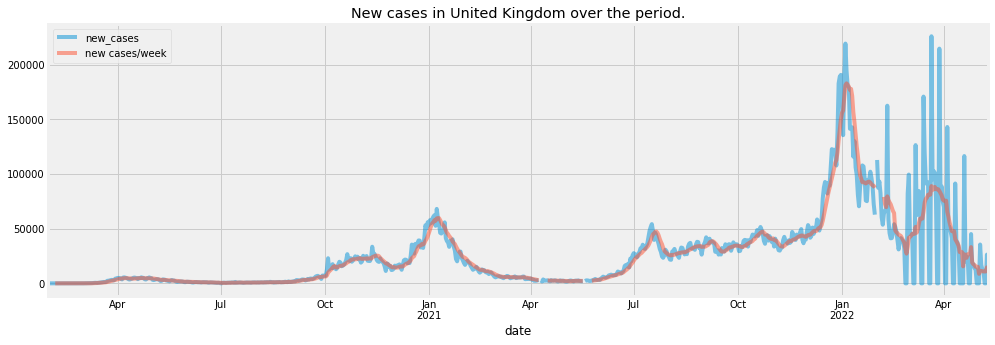

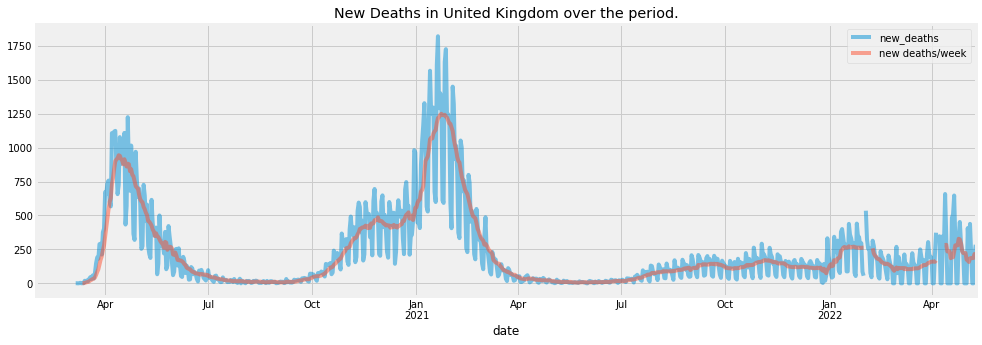

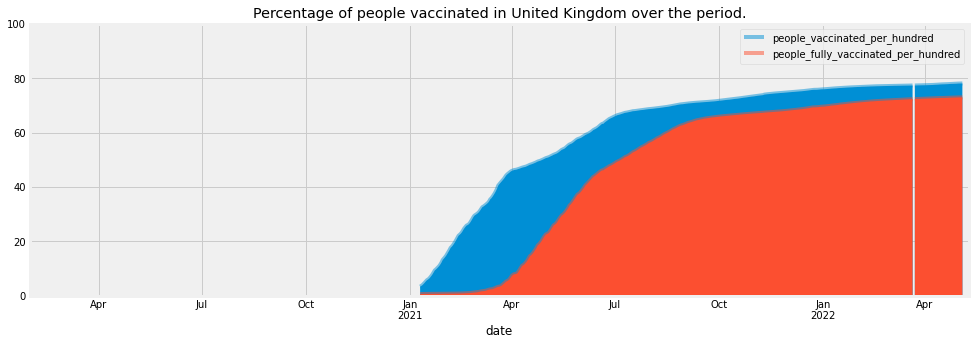

In [23]:
# Behaviour of Covid in UK
uk_covid = covid(data, 'United Kingdom')

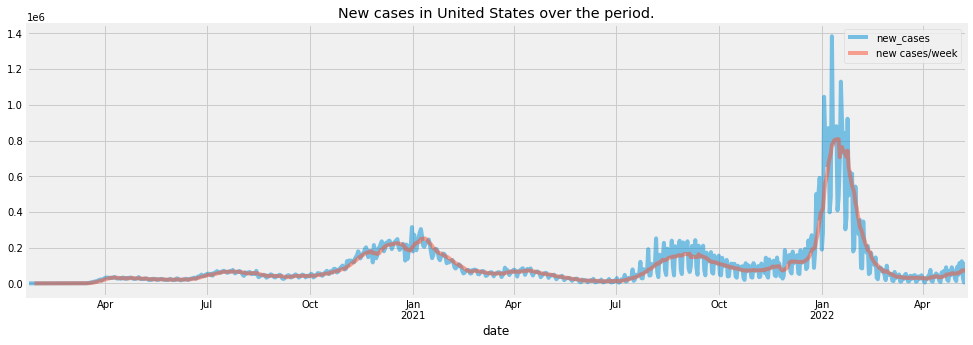

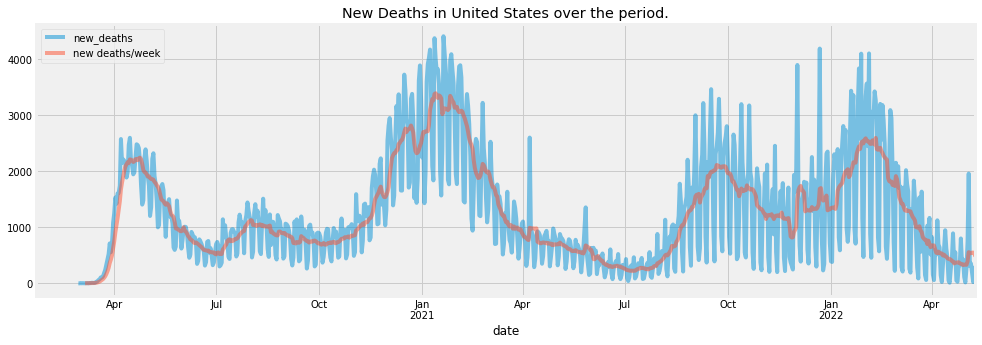

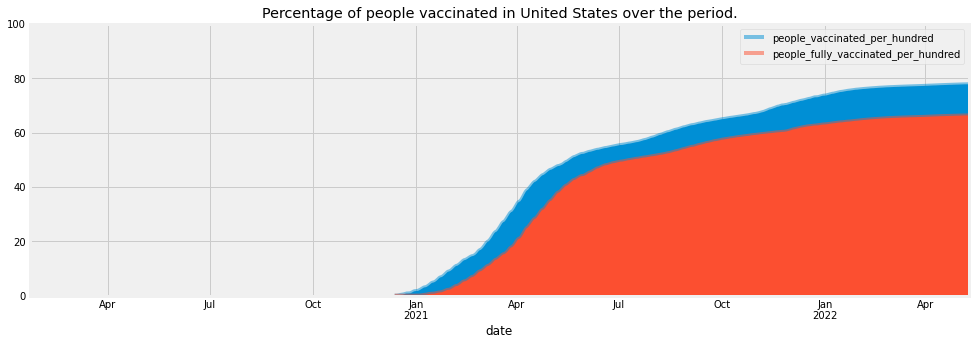

In [24]:
# Behaviour of Covid in USA
us_covid = covid(data, 'United States')

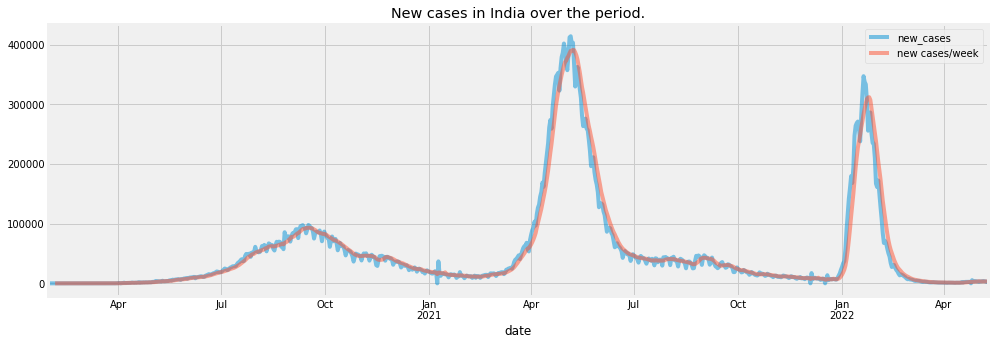

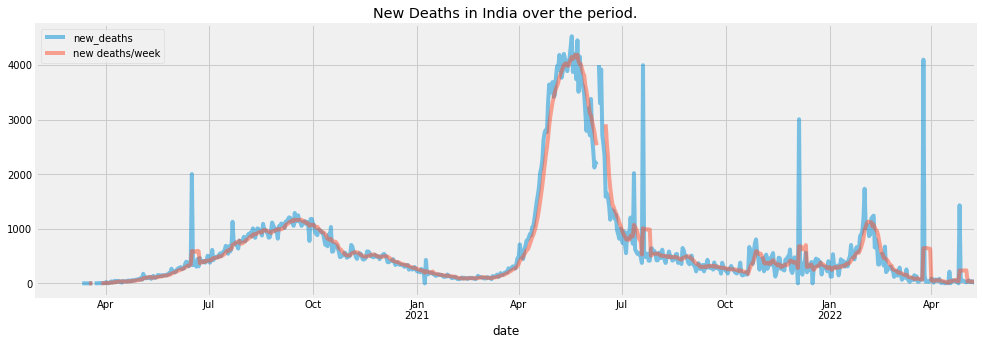

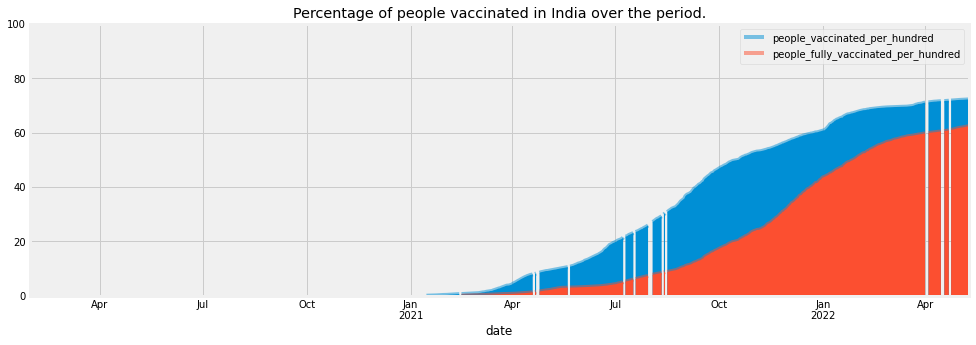

In [25]:
# Behaviour of Covid in INDIA
india_covid = covid(data, 'India')

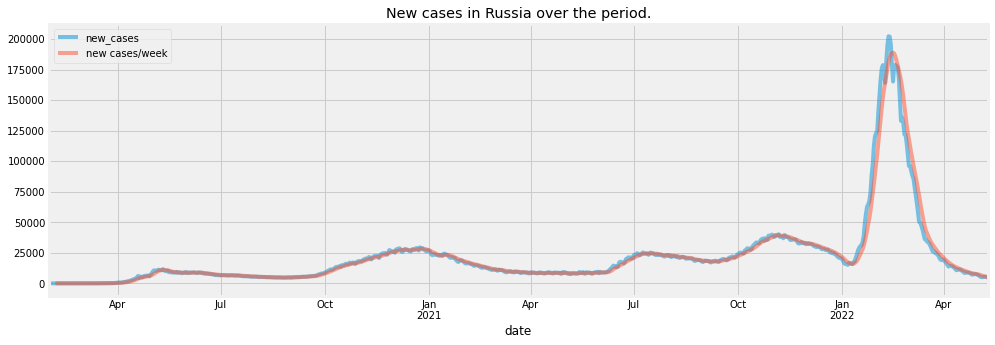

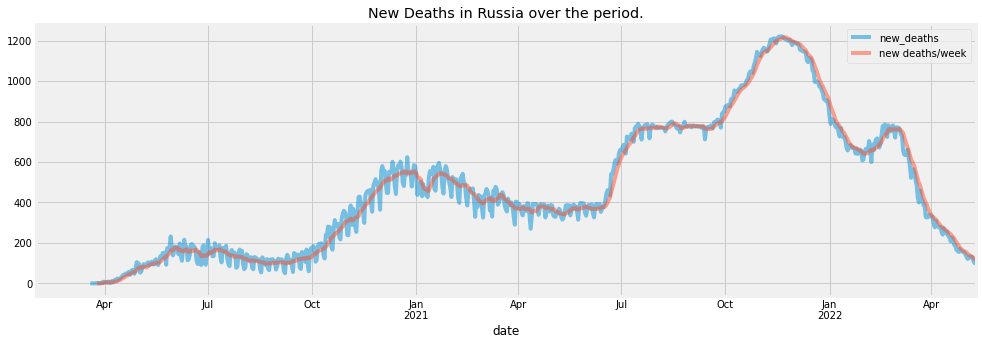

In [31]:
# Behaviour of Covid in Russia without the vaccination Status
russia_covid = covid(data, 'Russia')
plt.close()

In [28]:
# Creating the DataFrame with all the rolling means of above countries 
newdata = pd.DataFrame()
newdata['uk new cases per million'] = uk_covid['new cases per million/week']
newdata['us new cases per million'] = us_covid['new cases per million/week']
newdata['india new cases per million'] = india_covid['new cases per million/week']

newdata['uk new deaths per million'] = uk_covid['new deaths per million/week']
newdata['us new deaths per million'] = us_covid['new deaths per million/week']
newdata['india new deaths per million'] = india_covid['new deaths per million/week']

newdata.head()

,uk new cases per million,us new cases per million,india new cases per million,uk new deaths per million,us new deaths per million,india new deaths per million
date,,,,,,
2020-01-31,NaN,0.002571,NaN,NaN,NaN,NaN
2020-02-01,NaN,0.002571,NaN,NaN,NaN,NaN
2020-02-02,NaN,0.001286,NaN,NaN,NaN,NaN
2020-02-03,NaN,0.002571,NaN,NaN,NaN,NaN
2020-02-04,NaN,0.002571,NaN,NaN,NaN,NaN


AUC New cases per million in the UK:  305097.19257142855
AUC New cases per million in the US:  245843.74585714284
AUC New cases per million in India:  30932.46185714286


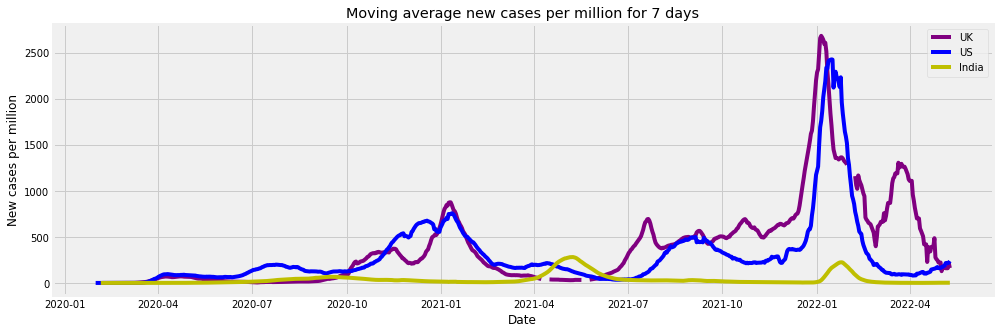

In [32]:
#Moving Avg new cases in the above three countries
plt.figure(figsize=(15, 5))
plt.plot(newdata.index, newdata['uk new cases per million'], color = 'purple', label="UK")
plt.plot(newdata.index, newdata['us new cases per million'], "-b", label="US")
plt.plot(newdata.index, newdata['india new cases per million'], "-y", label="India")
plt.legend(loc="upper right")
plt.title("Moving average new cases per million for 7 days")
plt.ylabel('New cases per million')
plt.xlabel('Date')

print('AUC New cases per million in the UK: ', newdata['uk new cases per million'].sum())
print('AUC New cases per million in the US: ', newdata['us new cases per million'].sum())
print('AUC New cases per million in India: ', newdata['india new cases per million'].sum())

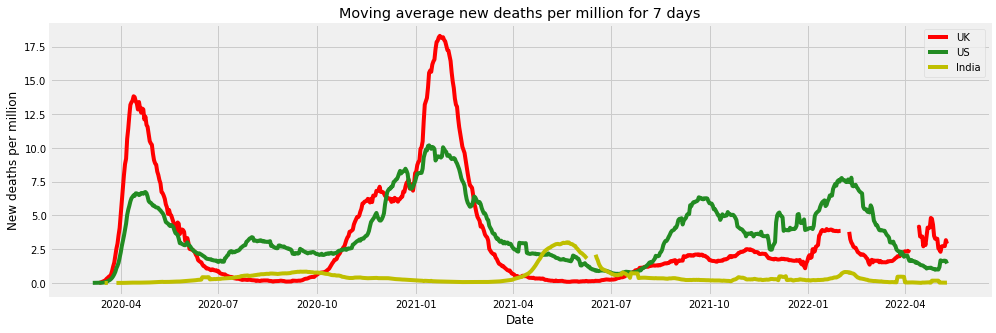

AUC New deaths per million in the UK:  2485.880857142857
AUC New deaths per million in the US:  2995.912
AUC New deaths per million in India:  358.46342857142855


In [33]:
# Moving Avg new death cases in the above three countries
plt.figure(figsize=(15, 5))
plt.plot(newdata.index, newdata['uk new deaths per million'], "-r", label="UK")
plt.plot(newdata.index, newdata['us new deaths per million'], color = 'forestgreen', label="US")
plt.plot(newdata.index, newdata['india new deaths per million'], "-y", label="India")
plt.legend(loc="upper right")
plt.title("Moving average new deaths per million for 7 days")
plt.ylabel('New deaths per million')
plt.xlabel('Date')
plt.show()

print('AUC New deaths per million in the UK: ', newdata['uk new deaths per million'].sum())
print('AUC New deaths per million in the US: ', newdata['us new deaths per million'].sum())
print('AUC New deaths per million in India: ', newdata['india new deaths per million'].sum())

In [34]:
# Creating a custom function to test and train the time series forecast
def covidmodel(country_data, country_name):
    newdf = country_data['new cases/week']
    if country_name == 'USA':
        newdf=newdf[7:].copy()
    else:
        newdf=newdf[6:].copy()  
    #Define the window and split the data with 80% of training data:
        win=10
        train_len = math.ceil(len(newdf)*0.8)
        train_data = newdf[0:train_len]
        X_train=[]
        Y_train=[]
        for i in range(win, len(train_data)):
            X_train.append(train_data[i-win:i])
            Y_train.append(train_data[i])
        X_train, Y_train= np.array(X_train), np.array(Y_train)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    #Define test set with remaining 20% of data
        test_data = newdf[train_len-win:]
        X_val=[]
        Y_val=[] 
        for i in range(win, len(test_data)):
            X_val.append(test_data[i-win:i])
            Y_val.append(test_data[i])
        X_val, Y_val = np.array(X_val), np.array(Y_val)
        X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

    #Build the RNN network and applying 3 dense layers 
        r1=[]
        r2=[]
        model=Sequential()
        model.add(SimpleRNN(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
        model.add(SimpleRNN(50,return_sequences=False,activation='relu'))
        model.add(Dense(100))
        model.add(Dense(25))
        model.add(Dense(1))
        opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
        model.compile(loss='mean_squared_error', optimizer=opt1)
        model.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=0)

    #Predict the label for train and validation sets, then compute RMSLE for both:
        lstm_train_pred = model.predict(X_train)
        lstm_valid_pred = model.predict(X_val)
    #As we will compute logaritmic the argument must be greater or equal to 0
        lstm_train_pred[lstm_train_pred<0] = 0  
        lstm_valid_pred[lstm_valid_pred<0] = 0
        print('RMSLE train set: ', np.round(np.sqrt(mean_squared_log_error(Y_train, lstm_train_pred)),3))
        print('RMSLE validation set: ', np.round(np.sqrt(mean_squared_log_error(Y_val, lstm_valid_pred)),3))
    
    #Create new dataframe including actual validation data and predicted validation:
        val = pd.DataFrame(newdf[train_len:])
        val['Predictions'] = model.predict(X_val)

    #Plot the both curves:
        plt.figure(figsize=(16,8))
        plt.title(f'Validation and predicted values by RNN model in {country_name}')
        plt.xlabel('Date')
        plt.ylabel('New cases')
        plt.plot(val[['new cases/week','Predictions']])
        plt.legend(['Validation','Predictions'])
        plt.show()

    #Return the new dataframe without NaN values, the model built and validation dataframe:
        return newdf.copy(), model, val

In [35]:
# Creating a custom function to predict the forecasted vaules.
def covidpredit(model, pred_data, days, country_name):
  #Loop for number of "days" to forecast:
  for i in range(1,days+1,1):
    #Take the last 10 days from the dataframe:
    last_10_days=pred_data[-10:].values
    X_test=[]
    X_test.append(last_10_days)
    X_test=np.array(X_test)
    #Reshape properly to be used by the model:
    X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    #Predict the one day in future given 10 days:
    pred_new_cases=model.predict(X_test)
    #Create the date for the forecasted value:
    idx = pd.date_range(pred_data.index[-1], periods=2, freq='D')[1:]
    #Append such value to the actual dataframe and use this new dataframe to compute a new future value:
    pred_data=pred_data.append(pd.Series(pred_new_cases[0][0], index=idx)).copy()

  #Plot the up to date values in blue and forecasted values in red:
  plt.figure(figsize=(16,8))
  plt.title(f'Historic values and forecasting of future values in {country_name}')
  plt.xlabel('Date')
  plt.ylabel('New cases')
  plt.plot(pred_data[:-days])
  plt.plot(pred_data[-days:])
  plt.legend(['Historic values','Forecasted'])
  plt.show()
 
 #Return the created dataframe including actual validation values and forecasted values.
  return pred_data

In [36]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

RMSLE train set:  0.074
RMSLE validation set:  0.143


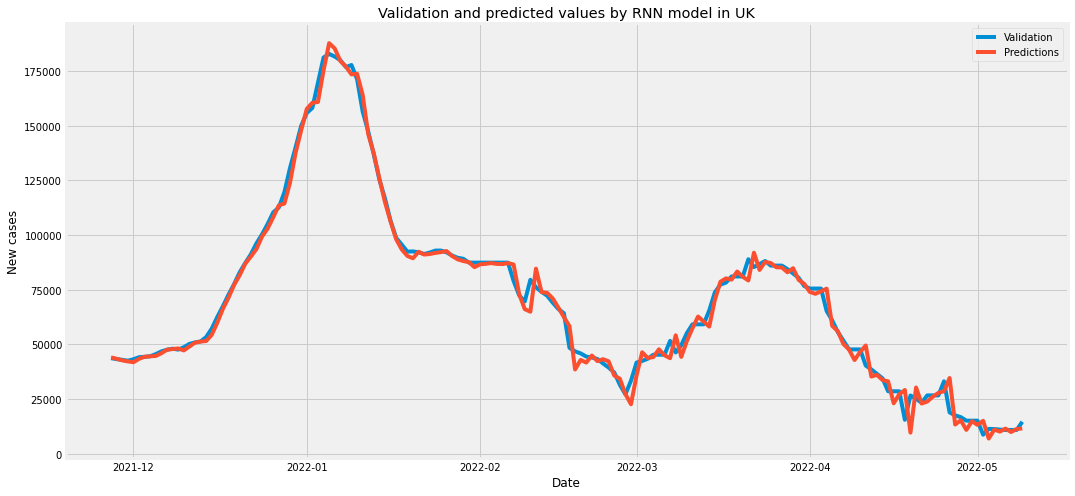

In [56]:
# Validation and prediction in UK
uk_covid[:-1] = uk_covid[:-1].ffill()
uk_data, model_uk, val_uk_data = covidmodel(uk_covid[:-1], 'UK')


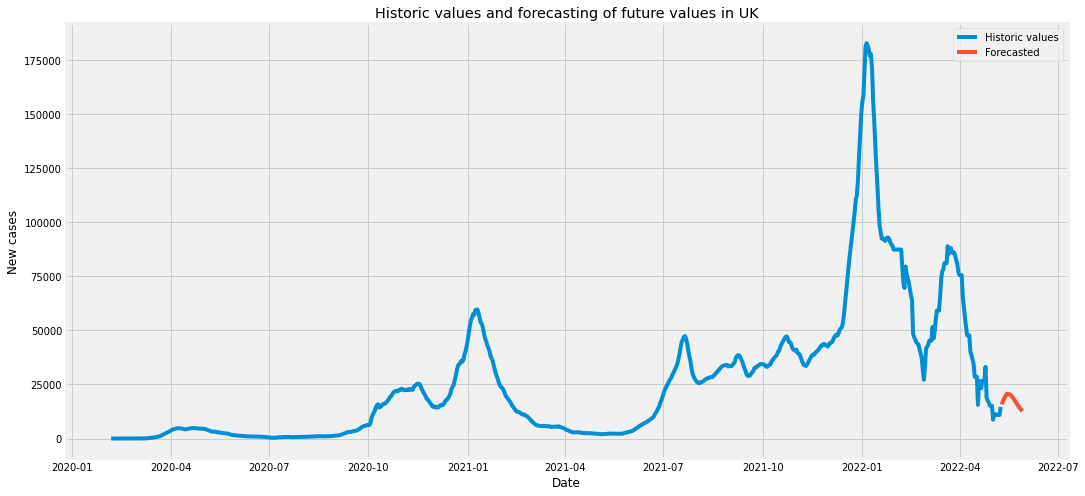

In [57]:
# Forecating the situation of covid in uk for the next 20 days
forecasting_uk = covidpredit(model_uk, uk_data, 20, 'UK')

RMSLE train set:  0.067
RMSLE validation set:  0.064


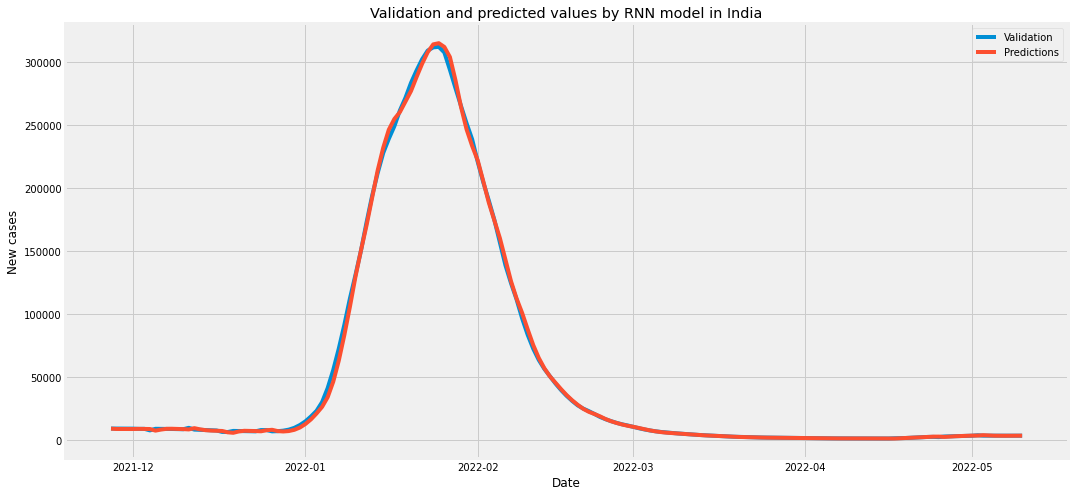

In [58]:
# Validation and prediction in India 
india_data, model_india, val_india = covidmodel(india_covid, 'India')

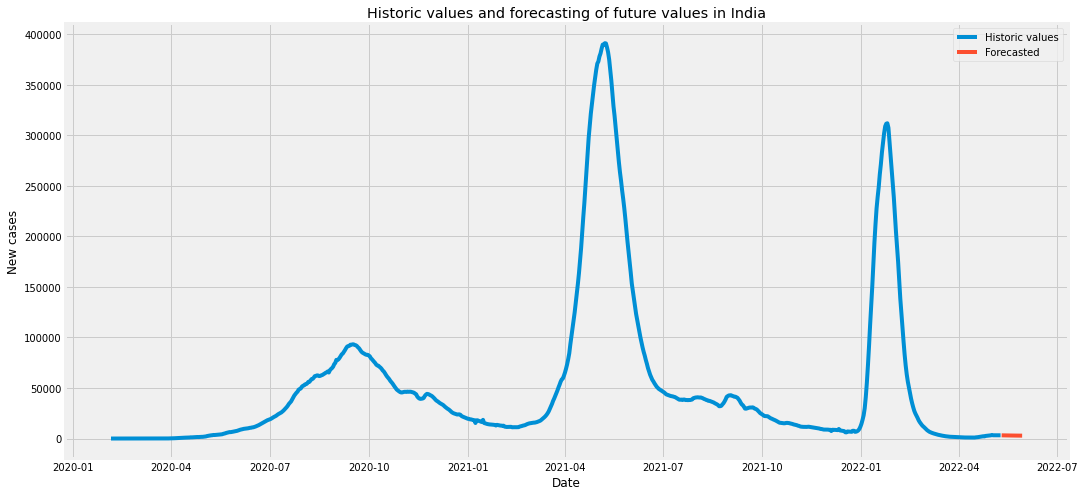

In [40]:
#Forecating the situation of covid in India for the next 20 days
forecasting_india = covidpredit(model_india, df_india_cut, 20, 'India')

RMSLE train set:  0.027
RMSLE validation set:  0.013


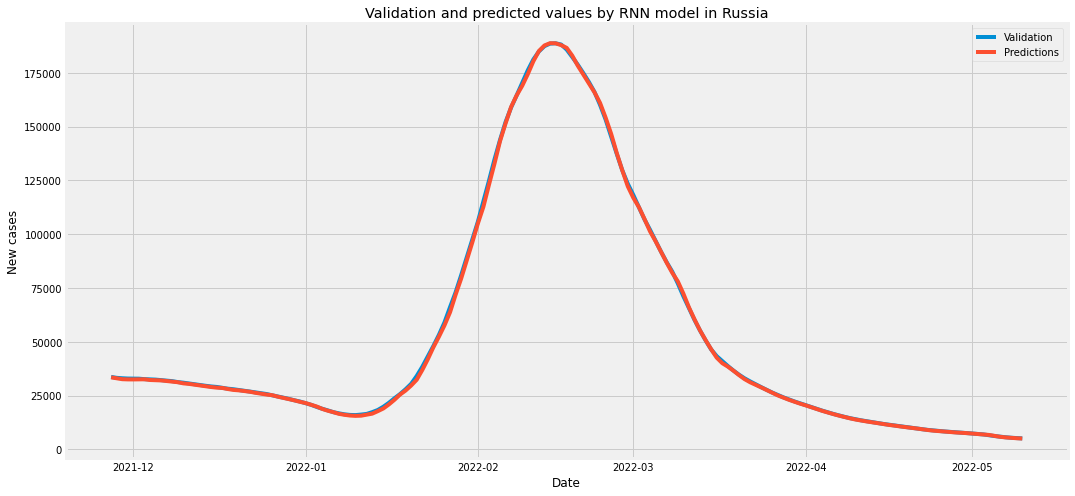

In [41]:
# Validation and prediction in Russia
df_Russia_cut, model_Russia, valid_df_Russia = covidmodel(russia_covid, 'Russia')

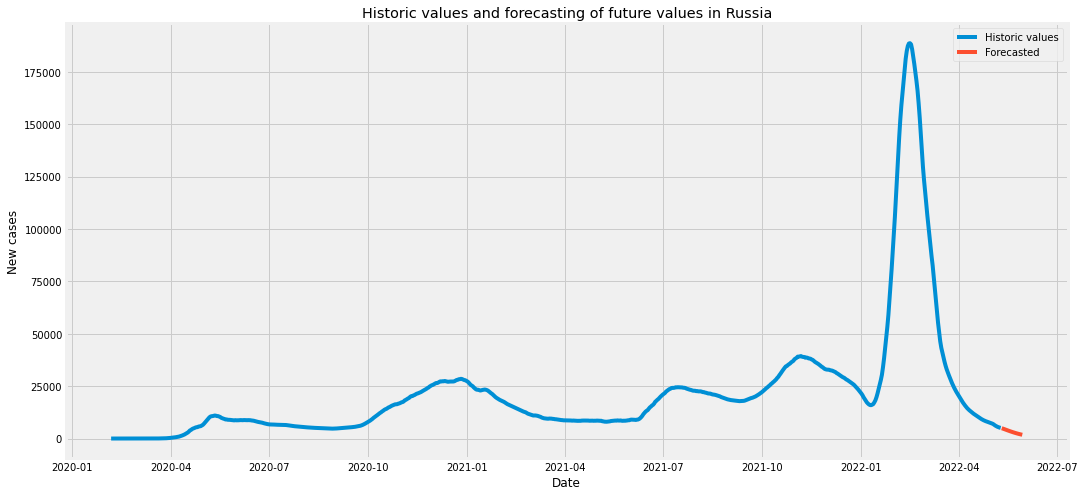

In [42]:
# Forecasting the situation od covid in Russia in the next 20 days.
forecasting_Russia = covidpredit(model_Russia, df_Russia_cut, 20, 'Russia')